<a href="https://colab.research.google.com/github/sayanbanerjee32/UNET/blob/main/UNET_StrConv_UpSamp_DiceLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNET implementation
- model: https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406
- data processing: https://www.kaggle.com/code/dhruv4930/oxford-iiit-pets-segmentation-using-pytorch

In [1]:
%%capture
!pip install torchmetrics

In [2]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchsummary import summary
import torchmetrics as TM

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

# Set the working (writable) directory.
working_dir = "./"

In [3]:
#import from local modules
SEED = 1
## function to check if GPU is available and return relevant device
def get_device():
    cuda = torch.cuda.is_available()
    print("CUDA Available?", cuda)
    # For reproducibility
    torch.manual_seed(SEED)
    if cuda:
        torch.cuda.manual_seed(SEED)
    return cuda, torch.device("cuda" if cuda else "cpu")

In [4]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


## Download Oxford pet dataset

In [5]:
# could not find the segmentation map in the Kaggle data
# !kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset

In [6]:
# %%capture
# !unzip the-oxfordiiit-pet-dataset.zip

In [7]:
# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

100%|██████████| 791918971/791918971 [00:29<00:00, 26770643.30it/s]


Extracting OxfordPets/train/oxford-iiit-pet/images.tar.gz to OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10531179.34it/s]


Extracting OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:29<00:00, 26763488.35it/s]


Extracting OxfordPets/test/oxford-iiit-pet/images.tar.gz to OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 11391173.07it/s]


Extracting OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to OxfordPets/test/oxford-iiit-pet


In [8]:
pets_train_orig, pets_test_orig

(Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: ./OxfordPets/train,
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: ./OxfordPets/test)

In [9]:
(train_pets_input, train_pets_target) = pets_train_orig[0]

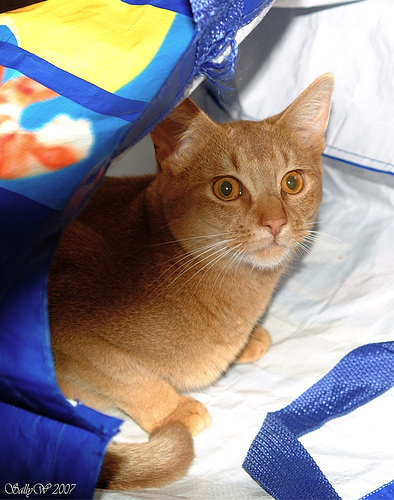

In [10]:
# Spot check an input image.
train_pets_input

## Trimap Legend
After subtracting 1 from pixel value. * 0 = Pet pixel (segmentation target) * 1 = background pixel * 2 = border (ambiguous) region pixel

In [11]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

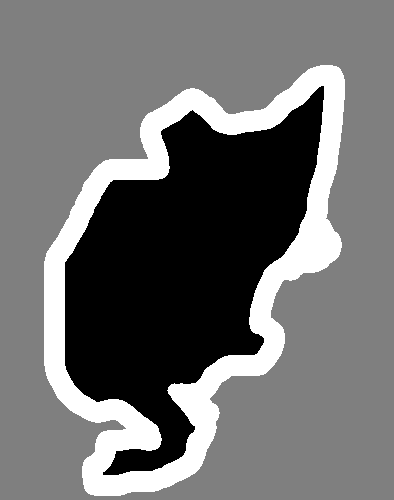

In [12]:
# Spot check a segmentation mask image after post-processing it
# via trimap2f().
t2img(trimap2f(train_pets_target))

## Load dataset

In [13]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In [14]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [15]:
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(device),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

## Spot check data

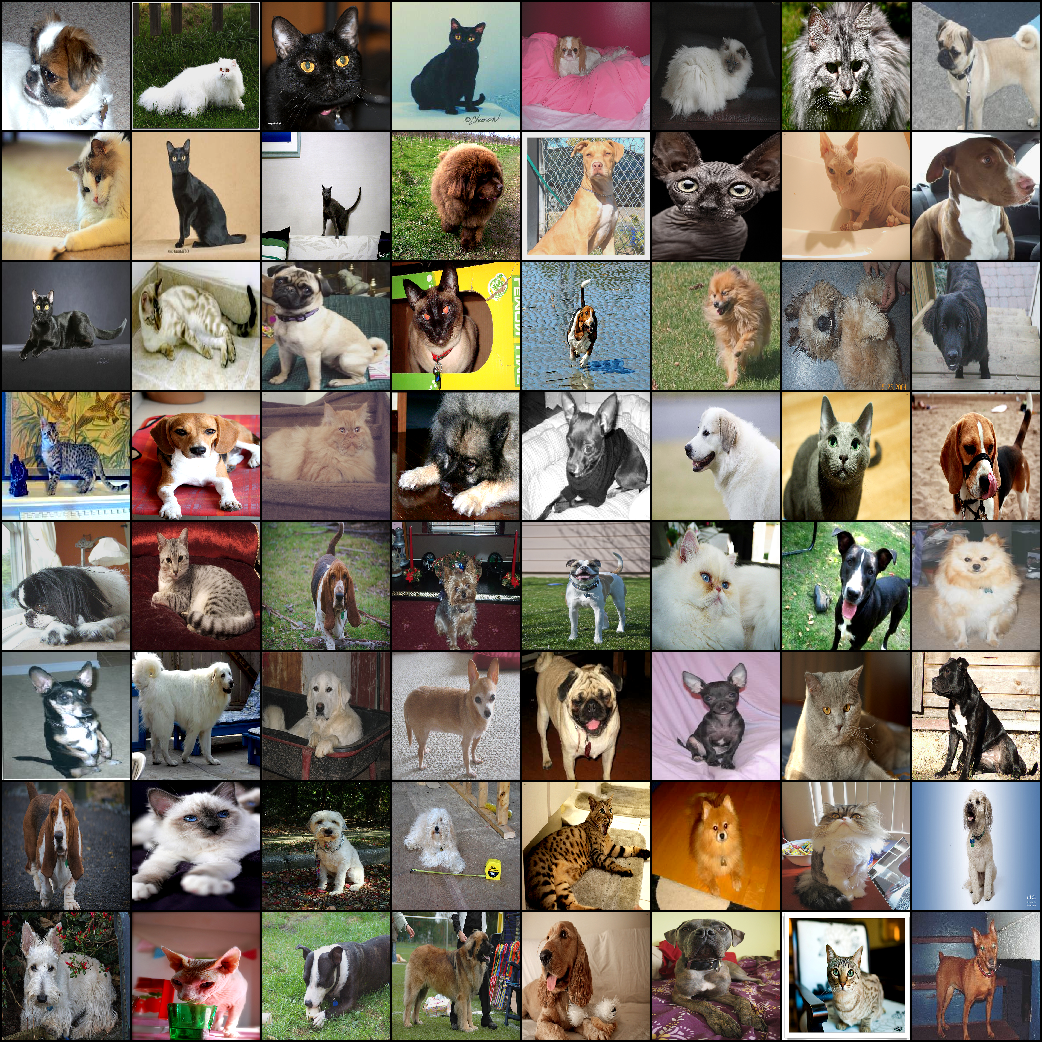

In [16]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

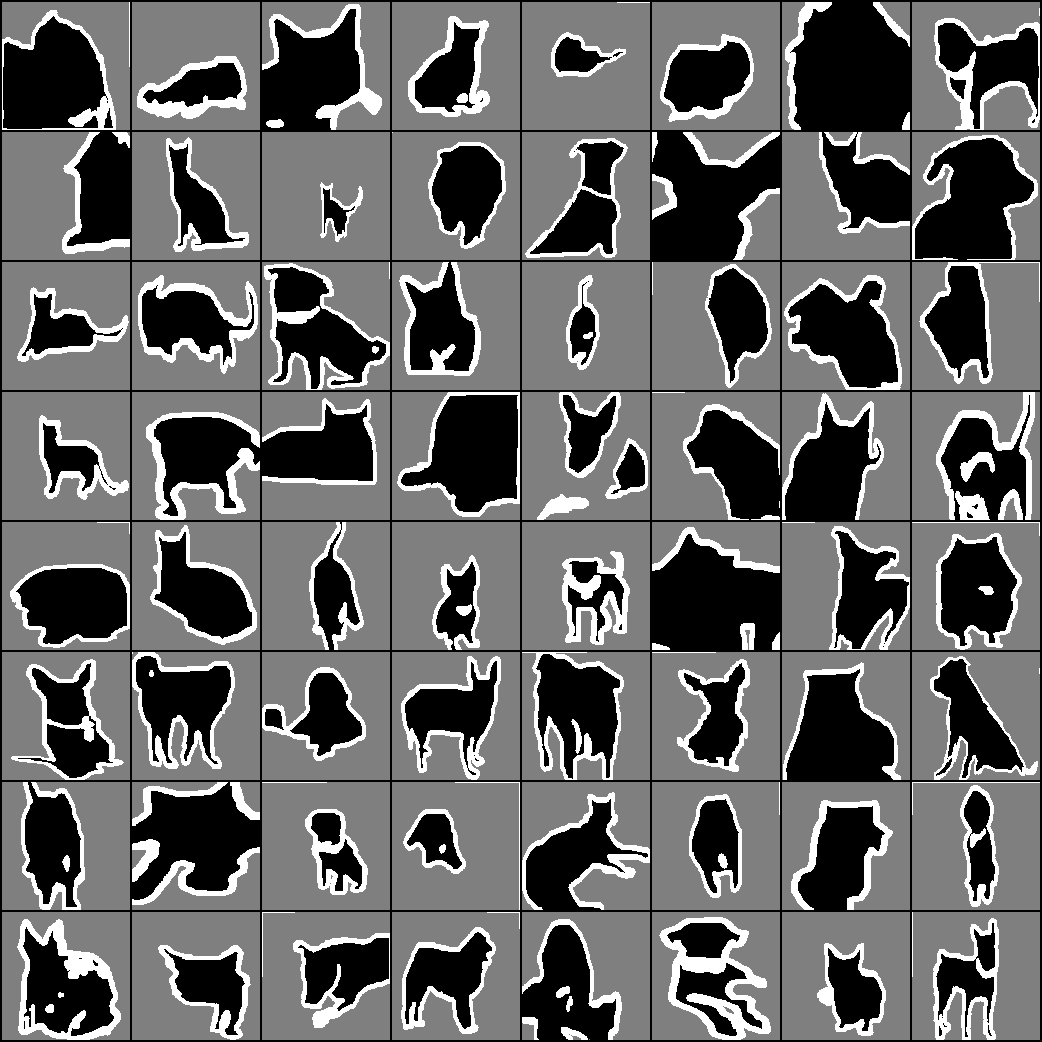

In [17]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

## U-Net

In [18]:
class EncoderMiniBlock(nn.Module):
    def __init__(self, in_channels, n_filters, dropout_prob=0.3, str_conv=True):
        super(EncoderMiniBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(n_filters)
        self.dropout = nn.Dropout(dropout_prob) if dropout_prob > 0 else None
        # self.max_pooling = nn.MaxPool2d(kernel_size=2, stride=2) if max_pooling else None
        self.str_conv = nn.Sequential(
            nn.Conv2d(in_channels=n_filters, out_channels=n_filters,
                      kernel_size=(3, 3), padding=1, stride = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters)
        ) if str_conv else None

    def forward(self, inputs):
        conv = self.conv1(inputs)
        conv = self.relu(conv)
        conv = self.conv2(conv)
        conv = self.relu(conv)
        conv = self.batchnorm(conv)
        if self.dropout:
            conv = self.dropout(conv)
        skip_connection = conv
        if self.str_conv:
            next_layer = self.str_conv(conv)
        else:
            next_layer = conv
        return next_layer, skip_connection

In [19]:
class DecoderMiniBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, n_filters):
        super(DecoderMiniBlock, self).__init__()
        # self.upconv = nn.ConvTranspose2d(in_channels, n_filters, kernel_size=2, stride=2)
        # self.conv1 = nn.Conv2d(n_filters + skip_channels, n_filters, kernel_size=3, padding=1)
        self.upsmpl = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(in_channels + skip_channels, n_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, prev_layer_input, skip_layer_input):
        up = self.upsmpl(prev_layer_input)
        merge = torch.cat([up, skip_layer_input], dim=1)
        conv = self.conv1(merge)
        conv = self.relu(conv)
        conv = self.conv2(conv)
        conv = self.relu(conv)
        return conv

In [20]:
class UNet(nn.Module):
    def __init__(self, input_size=(3, 128, 128), n_filters=32, n_classes=3):
        super(UNet, self).__init__()

        # Encoder
        self.encoder_block1 = EncoderMiniBlock(input_size[0], n_filters, dropout_prob=0) #64
        self.encoder_block2 = EncoderMiniBlock(n_filters, n_filters * 2, dropout_prob=0) #32
        self.encoder_block3 = EncoderMiniBlock(n_filters * 2, n_filters * 4, dropout_prob=0) #16
        self.encoder_block4 = EncoderMiniBlock(n_filters * 4, n_filters * 8) #8
        self.encoder_block5 = EncoderMiniBlock(n_filters * 8, n_filters * 16, str_conv=False) #8

        # Bottleneck
        # self.bottleneck = EncoderMiniBlock(n_filters * 16, n_filters * 32, max_pooling=False) #8

        # Decoder
        # self.decoder_block1 = DecoderMiniBlock(n_filters * 32, n_filters * 16, n_filters * 16) #16
        self.decoder_block1 = DecoderMiniBlock(n_filters * 16, n_filters * 8, n_filters * 8) #16
        self.decoder_block2 = DecoderMiniBlock(n_filters * 8, n_filters * 4, n_filters * 4)  #32
        self.decoder_block3 = DecoderMiniBlock(n_filters * 4, n_filters * 2, n_filters * 2) #64
        self.decoder_block4 = DecoderMiniBlock(n_filters * 2, n_filters, n_filters) #128


        # Output
        self.output_conv = nn.Conv2d(n_filters, n_classes, kernel_size=1)

    def forward(self, inputs):
        # Encoder
        enc1, skip1 = self.encoder_block1(inputs)
        enc2, skip2 = self.encoder_block2(enc1)
        enc3, skip3 = self.encoder_block3(enc2)
        enc4, skip4 = self.encoder_block4(enc3)
        enc5, _ = self.encoder_block5(enc4)

        # Bottleneck
        # bottleneck, _ = self.bottleneck(enc5)

        # Decoder
        dec1 = self.decoder_block1(enc5, skip4)
        dec2 = self.decoder_block2(dec1, skip3)
        dec3 = self.decoder_block3(dec2, skip2)
        dec4 = self.decoder_block4(dec3, skip1)
        # dec5 = self.decoder_block5(dec4, skip1)

        # Output
        output = self.output_conv(dec4)
        return output

In [21]:
unet = UNet().to(device)
summary(unet, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           9,248
              ReLU-4         [-1, 32, 128, 128]               0
       BatchNorm2d-5         [-1, 32, 128, 128]              64
            Conv2d-6           [-1, 32, 64, 64]           9,216
              ReLU-7           [-1, 32, 64, 64]               0
       BatchNorm2d-8           [-1, 32, 64, 64]              64
  EncoderMiniBlock-9  [[-1, 32, 64, 64], [-1, 32, 128, 128]]               0
           Conv2d-10           [-1, 64, 64, 64]          18,496
             ReLU-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,928
             ReLU-13           [-1, 64, 64, 64]               0
      BatchNorm2d-14      

In [22]:
# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
unet.eval().to(device)
unet(train_pets_inputs.to(device)).shape

torch.Size([64, 3, 128, 128])

### Loss function (Custom IoU and Custom IoU Loss)
We define a custom IoU metric that is differentiable so that it can be used as a loss functions if needed.

This IoU metric is different from the standard IoU metric that has a hard distinction between predicted classes by the model. In this custom IoU metric, we use the probability of the predicted class (after applying SoftMax) to determine the degree of overlap. In that sense, this isn't a pure IoU metric, but it does help us capture the essense of an IoU metric.

IoU is also sometimes called Jaccard Index or Jaccard similarity metric.

### Why use IoU instead of pixel accuracy?
For segmentation tasks, if you have input images where (say) just 10% of the image has the object you wish to cover with the object segmentation mask, and the rest of the image is supposed to be classified as background, then the pixel accuracy metric may not be the best metric to use.

Here's why. If the model were to predict every pixel as a background pixel, it would trivially achieve 90% accuracy for its prediction!

Hence, for cases where the object and background pixels are unbalanced, an IoU metric may be a better choice.

Here are some links to learn more about metrics for segmentation tasks:

https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388
https://towardsdatascience.com/evaluating-image-segmentation-models-1e9bb89a001b

In [23]:
# Define a custom IoU Metric for validating the model.
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    pred = pred.contiguous()
    gt = gt.contiguous()
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)
    # end if

    # Add the one-hot encoded masks for all 3 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([ (gt == i) for i in range(3) ], dim=1)
    # print(f"[2] Pred shape: {pred.shape}, gt shape: {gt.shape}")


    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)

    # Compute the mean over the batch dimension.
    return iou.mean()

# class IoULoss(nn.Module):
#     def __init__(self, softmax=False):
#         super().__init__()
#         self.softmax = softmax

#     # pred => Predictions (logits, B, 3, H, W)
#     # gt => Ground Truth Labales (B, 1, H, W)
#     def forward(self, pred, gt):
#         # return 1.0 - IoUMetric(pred, gt, self.softmax)
#         # Compute the negative log loss for stable training.
#         return -(IoUMetric(pred, gt, self.softmax).log())
#     # end def
# # end class
#https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
class DiceLoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax

    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # return 1.0 - IoUMetric(pred, gt, self.softmax)
        return ((1.0 - 2.0 * IoUMetric(pred, gt, self.softmax)))
        # Compute the negative log loss for stable training. - not working
        # return -((2.0 * IoUMetric(pred, gt, self.softmax)).log())
    # end def
# end class

def test_custom_iou_loss():
    #               B, C, H, W
    x = torch.rand((2, 3, 2, 2), requires_grad=True)
    y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
    z = DiceLoss(softmax=True)(x, y)
    return z
# end def

test_custom_iou_loss()

tensor(0.5878, grad_fn=<RsubBackward1>)

## Model Training

In [24]:
# Train the model for a single epoch
def train_model(model, loader, optimizer, scheduler):
    model.train().to(device)
    cel = False
    if cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = DiceLoss(softmax=True)
    # end if

    running_loss = 0.0
    running_samples = 0

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        # The ground truth labels have a channel dimension (NCHW).
        # We need to remove it before passing it into
        # CrossEntropyLoss so that it has shape (NHW) and each element
        # is a value representing the class of the pixel.
        if cel:
            targets = targets.squeeze(dim=1)
        # end if
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        running_samples += targets.size(0)
        running_loss += loss.item()
    # end for

    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))
# end def

### Helpers for validation of results on the test dataset

In [25]:
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
    # end while
# end def

def print_test_dataset_masks(model, test_pets_targets,
                             test_pets_labels, epoch, save_path, show_plot):
    model.eval().to(device)
    predictions = model(test_pets_targets.to(device))
    test_pets_labels = test_pets_labels.to(device)
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)

    # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
    iou = (TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND)).to(device)
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = (TM.classification.MulticlassAccuracy(3, average='micro')).to(device)
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    # end if

    if show_plot is False:
        close_figures()
    else:
        plt.show()
    # end if
# end def

In [26]:
def test_dataset_accuracy(model, loader):
    model.eval().to(device)
    iou = (TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND)).to(device)
    pixel_metric = (TM.classification.MulticlassAccuracy(3, average='micro')).to(device)

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    # print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = inputs.to(device)
        targets = targets.to(device)
        predictions = model(inputs)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())

        del inputs
        del targets
        del predictions
    # end for

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")

Epoch: 00, Accuracy[Pixel: 0.1185, IoU: 0.1700, Custom IoU: 0.1917]


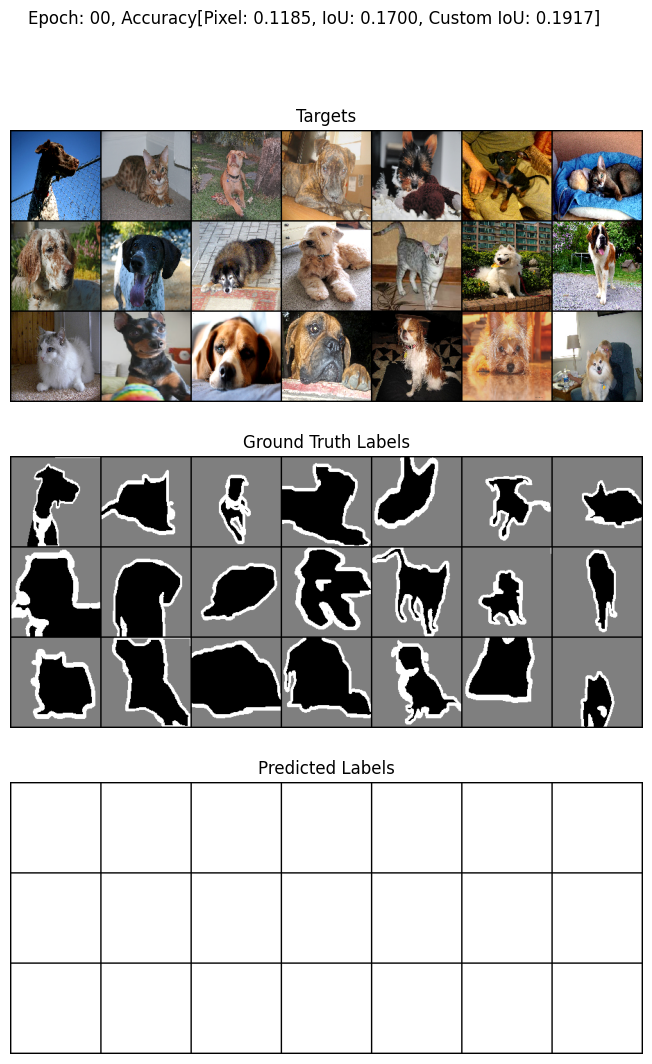

In [27]:
# Check if our helper functions work as expected and if the image
# is generated as expected.
# save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
# os.makedirs(save_path, exist_ok=True)
print_test_dataset_masks(unet, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)

In [28]:
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

num_epochs = 50
LRMAX = 0.001
LRMIN = LRMAX/10
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer  = optimizer, max_lr = LRMAX,
                                          anneal_strategy = 'linear',
                                          pct_start=0.3, div_factor=10,final_div_factor = 1,
                                          steps_per_epoch=len(pets_train_loader), epochs=num_epochs,
                                          three_phase = False)

In [29]:
# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path):
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer, scheduler)
        with torch.inference_mode():
            # Display the plt in the final training epoch.
            print_test_dataset_masks(model, test_inputs, test_targets, epoch=epoch, save_path=save_path, show_plot=(epoch % 10 == 0) or (epoch == epoch_j-1))
        # end with

        # if scheduler is not None:
        #     scheduler.step()
        # end if
        print("")
    # end for
# end def

Epoch: 01, Learning Rate: 0.0001
Trained 3680 samples, Loss: 0.2453
Epoch: 01, Accuracy[Pixel: 0.5945, IoU: 0.0062, Custom IoU: 0.4653]

Epoch: 02, Learning Rate: 0.00016006904487917147
Trained 3680 samples, Loss: -0.0199
Epoch: 02, Accuracy[Pixel: 0.7537, IoU: 0.4657, Custom IoU: 0.6081]

Epoch: 03, Learning Rate: 0.00022013808975834291
Trained 3680 samples, Loss: -0.2210
Epoch: 03, Accuracy[Pixel: 0.7143, IoU: 0.3242, Custom IoU: 0.5701]

Epoch: 04, Learning Rate: 0.0002802071346375144
Trained 3680 samples, Loss: -0.2837
Epoch: 04, Accuracy[Pixel: 0.7922, IoU: 0.5205, Custom IoU: 0.6623]

Epoch: 05, Learning Rate: 0.00034027617951668584
Trained 3680 samples, Loss: -0.3120
Epoch: 05, Accuracy[Pixel: 0.7837, IoU: 0.4964, Custom IoU: 0.6514]

Epoch: 06, Learning Rate: 0.0004003452243958573
Trained 3680 samples, Loss: -0.3285
Epoch: 06, Accuracy[Pixel: 0.7480, IoU: 0.4188, Custom IoU: 0.6147]

Epoch: 07, Learning Rate: 0.00046041426927502873
Trained 3680 samples, Loss: -0.3402
Epoch: 07,

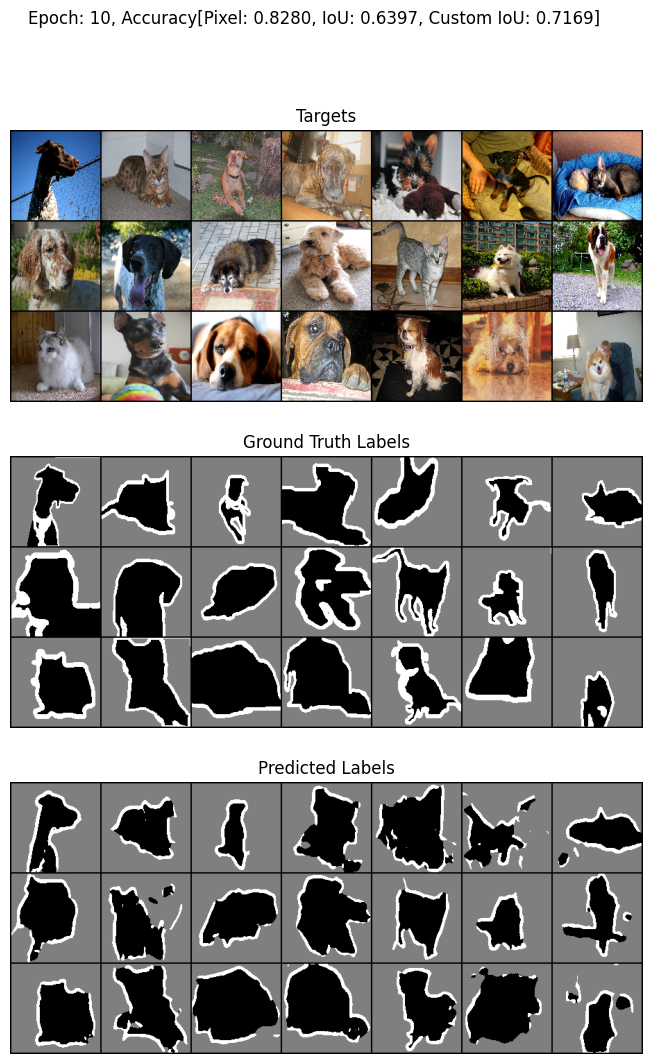


Epoch: 11, Learning Rate: 0.0007006904487917146
Trained 3680 samples, Loss: -0.4562
Epoch: 11, Accuracy[Pixel: 0.8404, IoU: 0.6564, Custom IoU: 0.7348]

Epoch: 12, Learning Rate: 0.0007607594936708861
Trained 3680 samples, Loss: -0.4789
Epoch: 12, Accuracy[Pixel: 0.8368, IoU: 0.6642, Custom IoU: 0.7315]

Epoch: 13, Learning Rate: 0.0008208285385500575
Trained 3680 samples, Loss: -0.5012
Epoch: 13, Accuracy[Pixel: 0.8225, IoU: 0.5897, Custom IoU: 0.7116]

Epoch: 14, Learning Rate: 0.000880897583429229
Trained 3680 samples, Loss: -0.4972
Epoch: 14, Accuracy[Pixel: 0.8471, IoU: 0.6629, Custom IoU: 0.7455]

Epoch: 15, Learning Rate: 0.0009409666283084004
Trained 3680 samples, Loss: -0.5149
Epoch: 15, Accuracy[Pixel: 0.8444, IoU: 0.6841, Custom IoU: 0.7435]

Epoch: 16, Learning Rate: 0.0009995566502463053
Trained 3680 samples, Loss: -0.5144
Epoch: 16, Accuracy[Pixel: 0.8366, IoU: 0.6218, Custom IoU: 0.7278]

Epoch: 17, Learning Rate: 0.0009738423645320197
Trained 3680 samples, Loss: -0.540

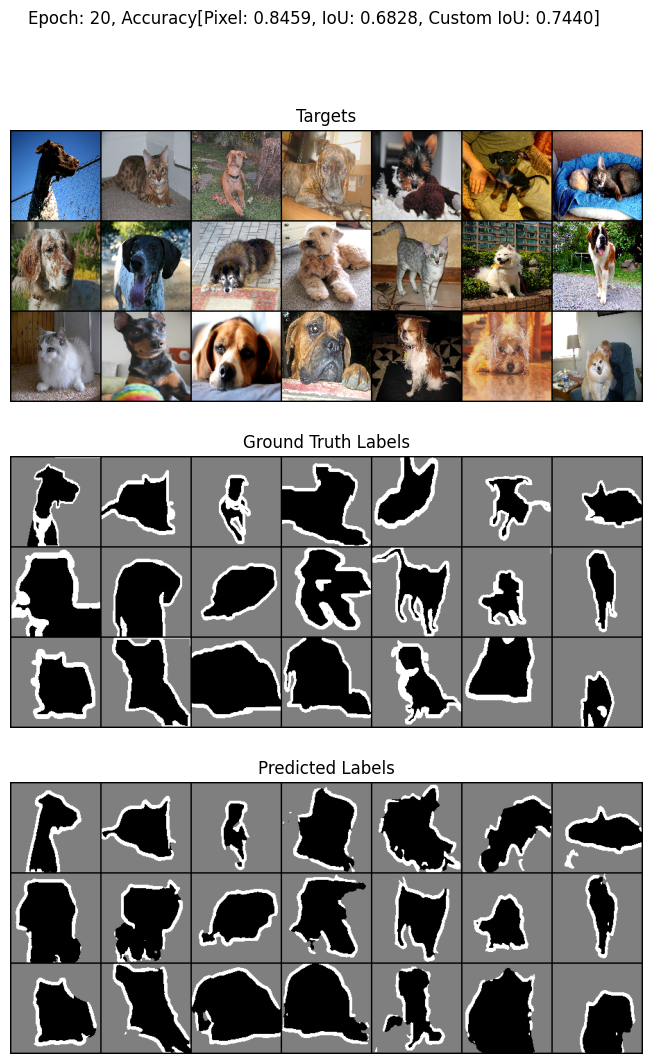


Epoch: 21, Learning Rate: 0.0008709852216748769
Trained 3680 samples, Loss: -0.5799
Epoch: 21, Accuracy[Pixel: 0.8700, IoU: 0.7018, Custom IoU: 0.7788]

Epoch: 22, Learning Rate: 0.0008452709359605911
Trained 3680 samples, Loss: -0.5833
Epoch: 22, Accuracy[Pixel: 0.8739, IoU: 0.7022, Custom IoU: 0.7846]

Epoch: 23, Learning Rate: 0.0008195566502463055
Trained 3680 samples, Loss: -0.5952
Epoch: 23, Accuracy[Pixel: 0.8572, IoU: 0.6732, Custom IoU: 0.7623]

Epoch: 24, Learning Rate: 0.0007938423645320197
Trained 3680 samples, Loss: -0.6057
Epoch: 24, Accuracy[Pixel: 0.8554, IoU: 0.7012, Custom IoU: 0.7618]

Epoch: 25, Learning Rate: 0.000768128078817734
Trained 3680 samples, Loss: -0.6108
Epoch: 25, Accuracy[Pixel: 0.8561, IoU: 0.7050, Custom IoU: 0.7623]

Epoch: 26, Learning Rate: 0.0007424137931034483
Trained 3680 samples, Loss: -0.6202
Epoch: 26, Accuracy[Pixel: 0.8651, IoU: 0.7003, Custom IoU: 0.7748]

Epoch: 27, Learning Rate: 0.0007166995073891626
Trained 3680 samples, Loss: -0.621

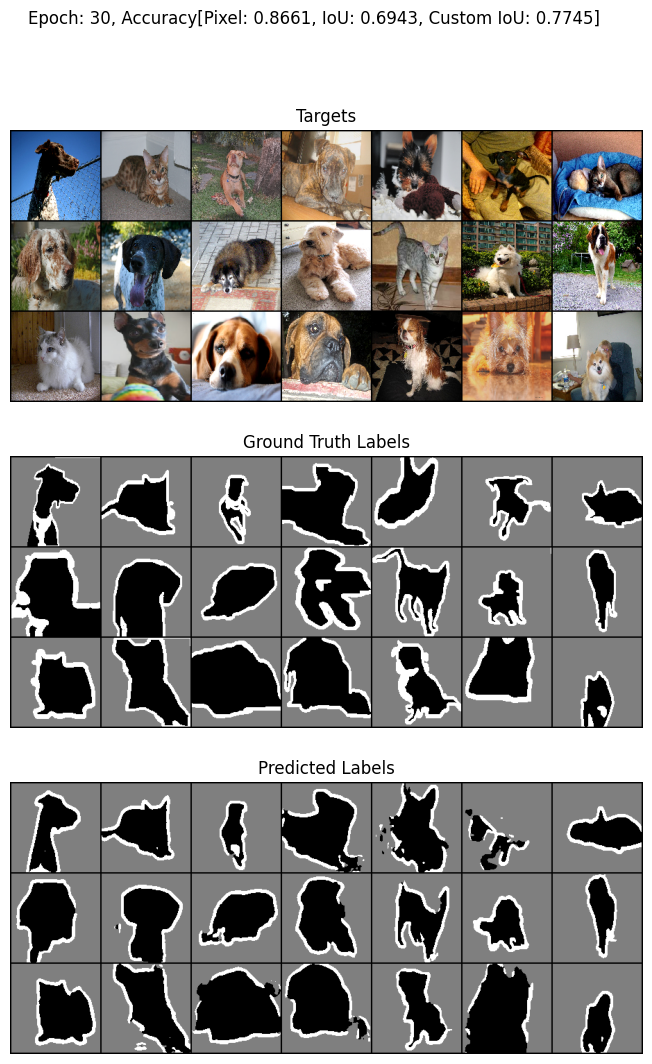


Epoch: 31, Learning Rate: 0.0006138423645320197
Trained 3680 samples, Loss: -0.6423
Epoch: 31, Accuracy[Pixel: 0.8708, IoU: 0.6902, Custom IoU: 0.7805]

Epoch: 32, Learning Rate: 0.0005881280788177341
Trained 3680 samples, Loss: -0.6481
Epoch: 32, Accuracy[Pixel: 0.8726, IoU: 0.6979, Custom IoU: 0.7811]

Epoch: 33, Learning Rate: 0.0005624137931034483
Trained 3680 samples, Loss: -0.6522
Epoch: 33, Accuracy[Pixel: 0.8636, IoU: 0.6917, Custom IoU: 0.7725]

Epoch: 34, Learning Rate: 0.0005366995073891627
Trained 3680 samples, Loss: -0.6529
Epoch: 34, Accuracy[Pixel: 0.8565, IoU: 0.6887, Custom IoU: 0.7632]

Epoch: 35, Learning Rate: 0.0005109852216748768
Trained 3680 samples, Loss: -0.6667
Epoch: 35, Accuracy[Pixel: 0.8707, IoU: 0.7075, Custom IoU: 0.7817]

Epoch: 36, Learning Rate: 0.00048527093596059114
Trained 3680 samples, Loss: -0.6750
Epoch: 36, Accuracy[Pixel: 0.8632, IoU: 0.6800, Custom IoU: 0.7700]

Epoch: 37, Learning Rate: 0.00045955665024630544
Trained 3680 samples, Loss: -0.

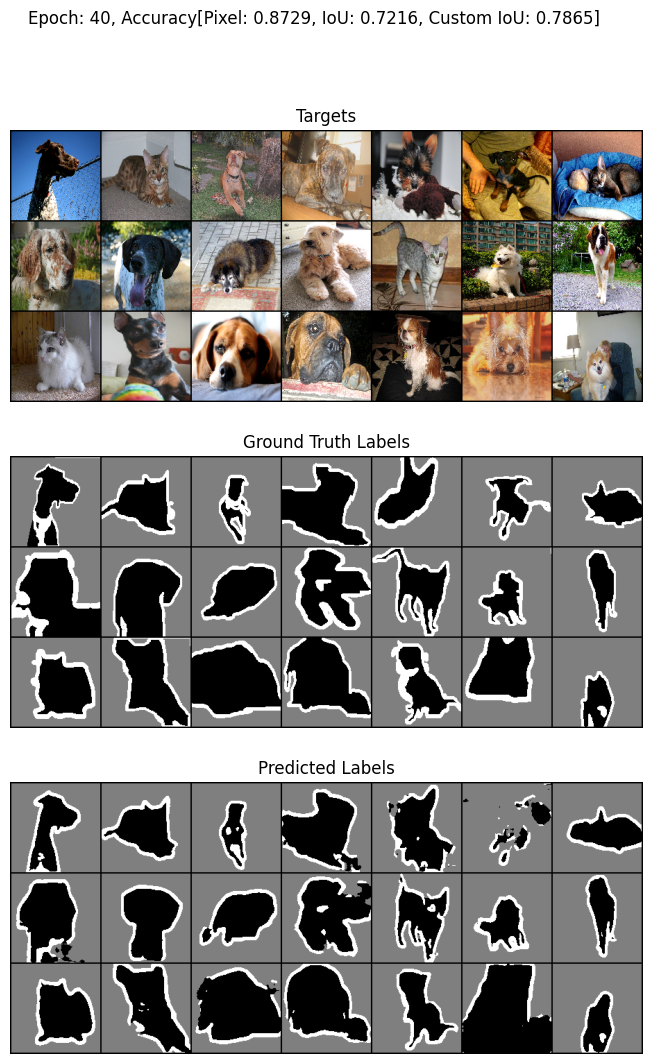


Epoch: 41, Learning Rate: 0.0003566995073891625
Trained 3680 samples, Loss: -0.6947
Epoch: 41, Accuracy[Pixel: 0.8781, IoU: 0.7212, Custom IoU: 0.7915]

Epoch: 42, Learning Rate: 0.0003309852216748769
Trained 3680 samples, Loss: -0.7007
Epoch: 42, Accuracy[Pixel: 0.8720, IoU: 0.7055, Custom IoU: 0.7830]

Epoch: 43, Learning Rate: 0.0003052709359605912
Trained 3680 samples, Loss: -0.7031
Epoch: 43, Accuracy[Pixel: 0.8695, IoU: 0.6970, Custom IoU: 0.7793]

Epoch: 44, Learning Rate: 0.0002795566502463055
Trained 3680 samples, Loss: -0.7072
Epoch: 44, Accuracy[Pixel: 0.8753, IoU: 0.7210, Custom IoU: 0.7894]

Epoch: 45, Learning Rate: 0.0002538423645320198
Trained 3680 samples, Loss: -0.7052
Epoch: 45, Accuracy[Pixel: 0.8696, IoU: 0.7074, Custom IoU: 0.7811]

Epoch: 46, Learning Rate: 0.000228128078817734
Trained 3680 samples, Loss: -0.7110
Epoch: 46, Accuracy[Pixel: 0.8692, IoU: 0.7116, Custom IoU: 0.7807]

Epoch: 47, Learning Rate: 0.0002024137931034483
Trained 3680 samples, Loss: -0.715

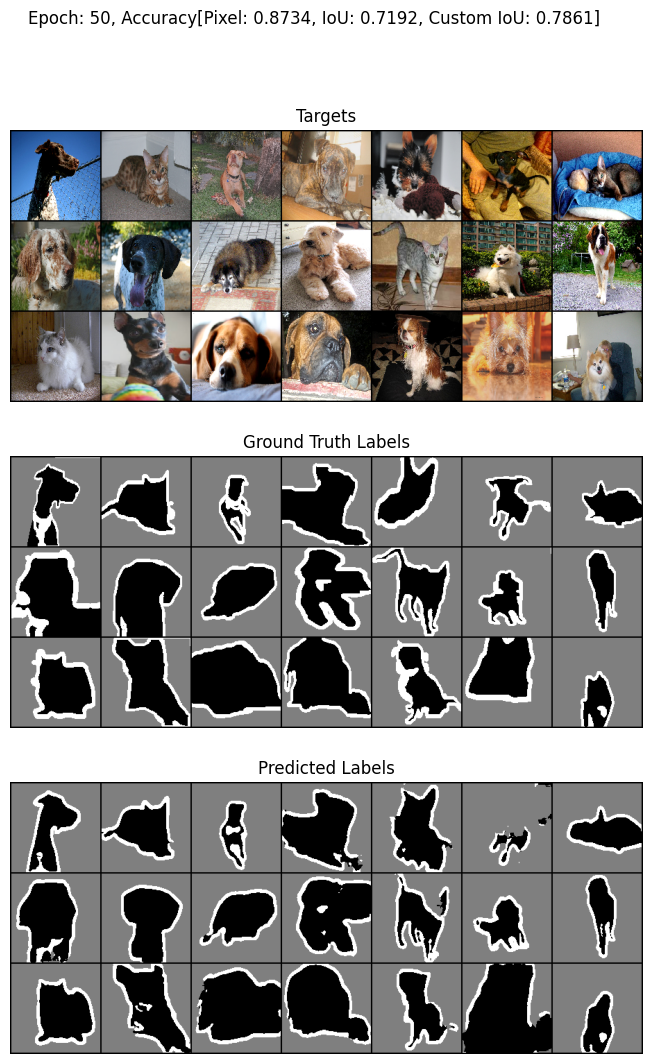

In [30]:
# save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
train_loop(unet, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, 1+num_epochs), optimizer, scheduler, None)

In [31]:
# Let's test the accuracy of the model on the test dataset.
with torch.inference_mode():
    test_dataset_accuracy(unet, pets_test_loader)

Test Dataset Accuracy
Pixel Accuracy: 0.9034, IoU Accuracy: 0.7614, Custom IoU Accuracy: 0.8305
